# Kaggle House Price Prediction: Advanced Regression
### Project Goal:
Predict the final price of each home using 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

### Skills Demonstrated:
* Data Cleaning & Imputation
* Feature Encoding (One-Hot Encoding)
* Linear Regression Modeling
* Model Evaluation (RMSE)

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# for reproducibility
tf.random.set_seed(42)
np.set_printoptions(precision=3, suppress=True)

## 2. Load the Data

In [2]:
# Load dataset
train_df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

# Drop the 'Id' column as it's not a predictor
train_df.drop('Id', axis=1, inplace=True)

print(f"Dataset Shape: {train_df.shape}")
print(train_df.info())

Dataset Shape: (1460, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-nu

In [3]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Simplified Data Cleaning

In [4]:
# Drop columns with more than 80% missing values
train_df = train_df.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

# Drop rows where 'SalePrice' is missing
train_df = train_df.dropna(subset=['SalePrice'])

# Separate numerical and categorical columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_df.select_dtypes(include=['object']).columns

# Fill missing numerical values with median
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Fill missing categorical values with "None"
train_df[cat_cols] = train_df[cat_cols].fillna('None')

## 4. Feature Encoding

In [5]:
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

# List of columns that use this specific scale
ord_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
            'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for col in ord_cols:
    train_df[col] = train_df[col].map(quality_map)

# Convert 'CentralAir' to binary
train_df['CentralAir'] = train_df['CentralAir'].map({'Y': 1, 'N': 0})

# Create dummy variables for categorical data. Using One-Hot Encoding
train_final = pd.get_dummies(train_df)

print(f"Final Data Shape after Encoding: {train_final.shape}")

Final Data Shape after Encoding: (1460, 249)


In [6]:
# New features
train_final['TotalSF'] = train_final['TotalBsmtSF'] + train_final['1stFlrSF'] + train_final['2ndFlrSF']
train_final['TotalBath'] = (train_final['FullBath'] + 0.5 * train_final['HalfBath'] + train_final['BsmtFullBath'] + 0.5 * train_final['BsmtHalfBath'])
train_final['Age'] = train_final['YrSold'] - train_final['YearBuilt']
train_final['IsRemodeled'] = (train_final['YearBuilt'] != train_final['YearRemodAdd']).astype(int)
train_final['TotalPorchSF'] = (train_final['OpenPorchSF'] + train_final['EnclosedPorch'] + train_final['3SsnPorch'] + train_final['ScreenPorch'])

# Log scale the target variable to reduce skewness
train_final['SalePrice_Log'] = np.log1p(train_final['SalePrice'])

### Correlation Matrix

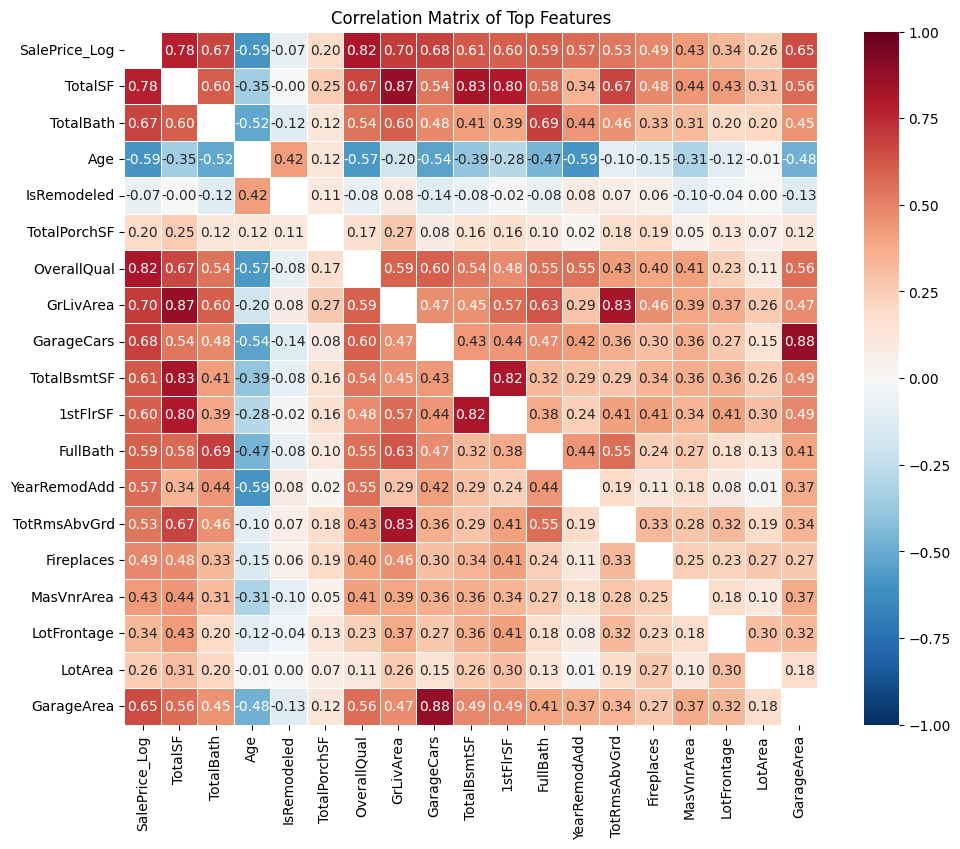

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the list of features to analyze
corr_features = [
    'SalePrice_Log', 'TotalSF', 'TotalBath', 'Age', 'IsRemodeled', 'TotalPorchSF',
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 
    'FullBath', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 
    'MasVnrArea', 'LotFrontage', 'LotArea', 'GarageArea'
]

# 2. Calculate the correlation matrix
corrmat = train_final[corr_features].corr()

# 3. Create a mask for the diagonal (self-correlation)
mask = np.eye(len(corrmat), dtype=bool)

# 4. Plot the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, fmt='.2f', cmap='RdBu_r', square=True, 
            mask=mask, vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Correlation Matrix of Top Features')
plt.show()

In [ ]:


# Define Features (X) and Target (y)
X = train_final.drop('SalePrice', axis=1)
y = np.log1p(train_final['SalePrice'])

# Split: 80% train, 20% cv (cross-validation)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"CV Set Shape: {X_cv.shape}, {y_cv.shape}")

Training Set Shape: (1168, 254), (1168,)
CV Set Shape: (292, 254), (292,)
